In [1]:
from qiskit import *
from qiskit.converters import circuit_to_dag
from qiskit.quantum_info import Operator
from qiskit.circuit.library.standard_gates import CPhaseGate, PhaseGate
from qiskit.circuit.library import QFT
from qiskit.visualization import array_to_latex

import quimb as qu
import quimb.tensor as qtn

import numpy as np

# Full QFT MPO circuit implementation

In [65]:
# Num qubits
N = 4
# 10 qubits and tag the initial wavefunction tensors
circ = qtn.Circuit(N=N)
circ.apply_gate('H', 0, gate_round=0)

circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [0, 1], gate_round=0, tags='P(pi/2)')
circ.apply_gate_raw(PhaseGate(np.pi/4).to_matrix(), [2], gate_round=0, tags='P(pi/4)')
circ.apply_gate_raw(PhaseGate(np.pi/8).to_matrix(), [3], gate_round=0, tags='P(pi/8)')

circ.apply_gate('H', 1, gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [1, 2], gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/4).to_matrix(), [1, 3], gate_round=0)

circ.apply_gate('H', 2, gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [2, 3], gate_round=0)

circ.apply_gate('H', 3, gate_round=0)

circ_tensors = circ.psi.tensors

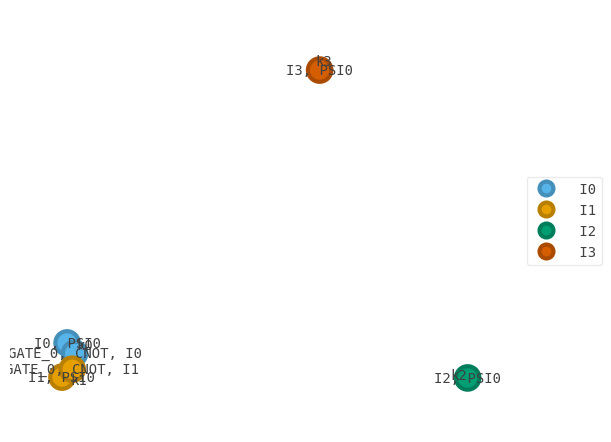

In [169]:
circ.psi.draw(color=[f'I{q}' for q in range(N)])

# Phase Tensor MPO

In [170]:
def getQ(row, col):
    return f'q{row},{col}'

def getC(row, col):
    return f'c{row},{col}'


In [255]:
def get_haddard_MPO(N, row, col):
    """
    Get the MPO for the Hadamard gate and place it at the given row and col
    """
    tensors = []
    for i in range(N):
        inds=[getQ(i, col), getQ(i, col+1)]
        if i == row:
            tensors.append(qtn.Tensor(qu.hadamard(), inds=inds, tags='H'))
        else:
            tensors.append(qtn.Tensor(np.eye(2), inds=inds, tags='I'))

    return tensors

In [221]:
hadamard_mp = get_haddard_MPO(0, 0)
qtn.TensorNetwork(hadamard_mp).draw(color=['H'])

TypeError: get_haddard_MPO() takes 2 positional arguments but 3 were given

In [256]:
def get_phase_MPO(start_row, end_row, col):
    '''
    Returns a tensor network MPO representing the controlled phase gates
    '''

    tensors = []

    for i in range(0, start_row):
        tensors.append(qtn.Tensor(qu.identity(2), inds=[getQ(i, col), getQ(i, col+1)], tags=['I']))

    # Define our control (copy tensor) in the form:
    # [ 
    #   [1, 0]  [0, 0] 
    #   [0, 0], [0, 1] 
    # ]
    # (MPO-QFT paper equation 53)
    copy_tensor = qtn.Tensor(
        data=np.array([ [[1, 0], [0,0]], [[0, 0], [0, 1]] ]), 
        inds=[getQ(start_row, col), getQ(start_row, col+1), getC(start_row, col)], 
        tags=['C'])

    tensors.append(copy_tensor)
    
    # Apply each of our controlled phase gates in the form:
    # [
    #   [1, 0]  [0, 0]
    #   [0, 1], [0, 0],
    #   [0, 0]  [1, 0]
    #   [0, 0], [0, e^iπ)]
    # ]
    # (MPO-QFT paper equation 53)
    phase_count = 1
    for i in range(start_row+1, end_row-1):
        phase_denom = (2**(phase_count))
        phase = np.pi/phase_denom
        inds=[getQ(i, col), getQ(i, col+1),getC(i-1, col), getC(i, col)]

        tensors.append(qtn.Tensor(
            data=CPhaseGate(phase).to_matrix().reshape(2,2,2,2),
            inds=inds,
            tags=['P', f'$\pi$/{phase_denom}']))

        phase_count += 1

    # Apply last phase gate in the form:
    # [ 
    #   [1, 0]
    #   [0, 1],
    #   [1, 0]
    #   [0, e^iπ)] 
    # ]
    # (MPO-QFT paper equation 53)
    last_phase = np.pi/(2**(phase_count))
    tensors.append(qtn.Tensor(
        data=[qu.identity(2), qu.phase_gate(last_phase)],
        inds=[getQ(end_row-1, col), getQ(end_row-1, col+1), getC(end_row-2, col)],
        tags=['P', f'$\pi$/{2**(phase_count)}']))
    
    return tensors

    

In [257]:
def merge_neighboring_indices(tn, end_row, end_col):
    """
    Merge neighboring indices of phase tensors 
    """
    start_row = 2
    start_col = 2
    for col in range(start_col, end_col, 2):
        for row in range(start_row, end_row):
            tn.reindex({getQ(row, col): getQ(row, col+1)}, inplace=True)


[Tensor(shape=(2, 2), inds=('q0,0', 'q0,1'), tags=oset(['H'])), Tensor(shape=(2, 2), inds=('q1,0', 'q1,1'), tags=oset(['I'])), Tensor(shape=(2, 2), inds=('q2,0', 'q2,1'), tags=oset(['I'])), Tensor(shape=(2, 2), inds=('q3,0', 'q3,1'), tags=oset(['I'])), Tensor(shape=(2, 2, 2), inds=('q0,1', 'q0,2', 'c0,1'), tags=oset(['C'])), Tensor(shape=(2, 2, 2, 2), inds=('q1,1', 'q1,2', 'c0,1', 'c1,1'), tags=oset(['P', '$\\pi$/2'])), Tensor(shape=(2, 2, 2, 2), inds=('q2,1', 'q2,2', 'c1,1', 'c2,1'), tags=oset(['P', '$\\pi$/4'])), Tensor(shape=(2, 2, 2), inds=('q3,1', 'q3,2', 'c2,1'), tags=oset(['P', '$\\pi$/8'])), Tensor(shape=(2, 2), inds=('q0,2', 'q0,3'), tags=oset(['I'])), Tensor(shape=(2, 2), inds=('q1,2', 'q1,3'), tags=oset(['H'])), Tensor(shape=(2, 2), inds=('q2,2', 'q2,3'), tags=oset(['I'])), Tensor(shape=(2, 2), inds=('q3,2', 'q3,3'), tags=oset(['I'])), Tensor(shape=(2, 2), inds=('q0,3', 'q0,4'), tags=oset(['I'])), Tensor(shape=(2, 2, 2), inds=('q1,3', 'q1,4', 'c1,3'), tags=oset(['C'])), Tens

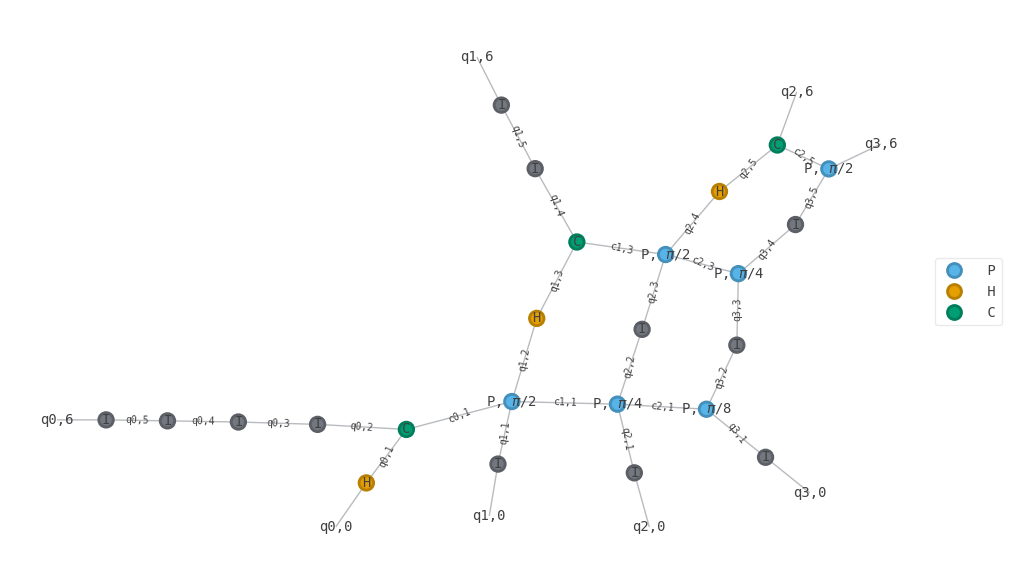

In [274]:
tensors = []

tensors.extend(get_haddard_MPO(N, 0, 0))
tensors.extend(get_phase_MPO(0, N, 1))
tensors.extend(get_haddard_MPO(N, 1, 2))
tensors.extend(get_phase_MPO(1, N, 3))
tensors.extend(get_haddard_MPO(N, 2, 4))
tensors.extend(get_phase_MPO(2, N, 5))
# tensors.extend(get_haddard_MPO(N, 3, 6))
print(tensors)
tn = qtn.TensorNetwork2D(tensors)
# merge_neighboring_indices(tn, N, N+1)
tn.draw(color=['P','H', 'C'], figsize=(10, 10), show_inds='all', show_tags=True, iterations=100)

In [239]:
phase_mpo1 = get_phase_MPO(N, 1, N, 2)
phase_mpo1.draw(color=['P'], figsize=(10, 10), show_inds='all', show_tags=True)

TypeError: get_phase_MPO() takes 3 positional arguments but 4 were given

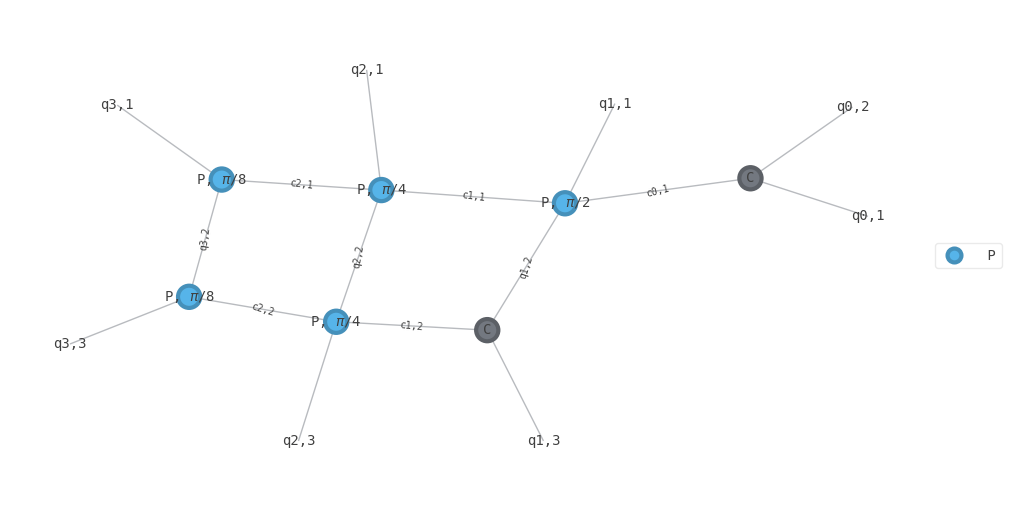

In [182]:
phase_mpo0.add_tensor_network(phase_mpo1, virtual=True)
phase_mpo0.draw(color=['P'], figsize=(10, 10), show_inds='all', show_tags=True)

In [135]:
def zip_up(tn, N):
    for i in range(N-1, 0):

SyntaxError: incomplete input (2684517071.py, line 2)

In [146]:
sorted_circ_tensors = circ.psi.tensors

for i in range(0, len(sorted_circ_tensors), 1):
    print(f"{i}: {sorted_circ_tensors[i]}")


# Contract phase tensors
contracted_tensor = sorted_circ_tensors[10] @ sorted_circ_tensors[15]

print(contracted_tensor)

# Split the tensor with svd
svd_tn = qtn.tensor_core.tensor_split(contracted_tensor, left_inds='_fe41d3AAAAI')

print(svd_tn)



0: Tensor(shape=(2,), inds=('_fe41d3AAABM',), tags=oset(['I0', 'PSI0']), backend='numpy', dtype='complex128')
1: Tensor(shape=(2,), inds=('_fe41d3AAABO',), tags=oset(['I1', 'PSI0']), backend='numpy', dtype='complex128')
2: Tensor(shape=(2,), inds=('_fe41d3AAABP',), tags=oset(['I2', 'PSI0']), backend='numpy', dtype='complex128')
3: Tensor(shape=(2,), inds=('_fe41d3AAABQ',), tags=oset(['I3', 'PSI0']), backend='numpy', dtype='complex128')
4: Tensor(shape=(2, 2), inds=('_fe41d3AAABN', '_fe41d3AAABM'), tags=oset(['GATE_0', 'ROUND_0', 'H', 'I0']), backend='numpy', dtype='complex128')
5: Tensor(shape=(2, 2, 2), inds=('k0', '_fe41d3AAABN', 'b'), tags=oset(['P(pi/2)', 'GATE_1', 'ROUND_0', 'I0']), backend='numpy', dtype='complex128')
6: Tensor(shape=(2, 2, 2), inds=('b', 'k1', '_fe41d3AAABO'), tags=oset(['P(pi/2)', 'GATE_1', 'ROUND_0', 'I1']), backend='numpy', dtype='complex128')
7: Tensor(shape=(2, 2), inds=('k2', '_fe41d3AAABP'), tags=oset(['P(pi/4)', 'GATE_2', 'ROUND_0', 'I2']), backend='nump

IndexError: tuple index out of range

In [ ]:
circ.schrodinger_contract()